In [1]:
import sys

import matplotlib.pyplot as plt
import json

import dysts
from dysts.flows import *
from dysts.base import *
from dysts.utils import *
from dysts.analysis import *

try:
    from private.lyap import lyap_r, lyap_e, corr_dim
except:
    from nolds import lyap_r, lyap_e, corr_dim
    


%load_ext autoreload
%autoreload 2

## Add a single dynamical system to the database

6.37


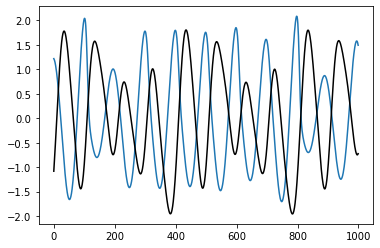

In [20]:
# Plot a reference trajectory as a sanity check
eq = Rossler()
sol = eq.make_trajectory(5000, resample=True, standardize=True)
plt.plot(sol[:1000, 0])

# Plot new system trajectory. For single-modal attractors, there should be ~10 dominant peaks in interval
eq = HenonHeiles()
# eq.period *= 1.01
# eq.dt = 0.01
# eq.period *= 5
# eq.ic = np.vstack([eq.ic, eq.ic, eq.ic, eq.ic])

sol = eq.make_trajectory(5000, resample=True, standardize=True)
# eq.ic = np.vstack([eq.ic, eq.ic])
plt.plot(sol[:1000, 0], 'k')
print(eq.period)

# Find dynamical properties of each system

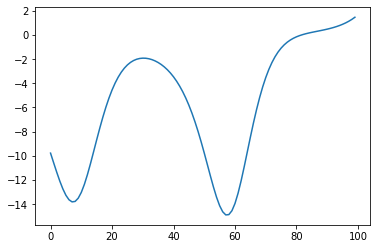

In [8]:
plt.plot(sol[:100, 0])

In [9]:
model = Lorenz()
sol = model.make_trajectory(10000, resample=True, pts_per_period=100)
corr_dim(sol)

2.00597102061605

In [23]:
# We will make a local copy of the internal database
OUTPUT_FILE = "./chaotic_attractors2.json"
# INPUT_FILE = "dysts/data/chaotic_attractors.json"
INPUT_FILE = "./dysts/data/chaotic_attractors.json"
INPUT_FILE = OUTPUT_FILE
RECALCULATE = True

points_to_sample = 10 # number of initial conditions to sample when computing values

with open(INPUT_FILE, "r") as file:
    data = json.load(file)
print(f"Total models being analyzed is {len(data.keys())}.")

for i, item in enumerate(list(data.keys())):
# for i, item in enumerate(get_attractor_list()):
# print(item)
    if i < 7:
        continue
    
    model = getattr(dysts.flows, item)()
    print(item, ": ", end="")
    current_fields = list(data.keys())
    
#     check_set = {"maximum_lyapunov_estimated", "lyapunov_spectrum", "correlation_dimension"}
#     if check_set.intersection(set(current_keys)) == check_set and not RECALCULATE:
#         print("All fields already filled; skipping calculation.")
#         continue
    
    model.dt /= 10
    sample_pts = sample_initial_conditions(model, points_to_sample)
    #print("Finished selecting initial points on attractor.")
    pts_per_trajectory = 15000 # number of timesteps to use to find the jacobian
    
    try:

        all_estimates_lyap = list()
        all_estimates_corrdim = list()
        for j, sample_pt in enumerate(sample_pts):
            print(".", end="")
            model.ic = sample_pt

            all_estimates_lyap.append(find_lyapunov_exponents(model, pts_per_trajectory, pts_per_period=500))

            sol = model.make_trajectory(10000, resample=True, pts_per_period=100)
            all_estimates_corrdim.append(corr_dim(sol))

        lyap = np.mean(np.array(all_estimates_lyap), axis=0)
        cdim = np.mean(all_estimates_corrdim)

        # lyap_minmag = np.min(np,abs(lyap))
        # dissipation = np.sum(lyap)

        # if dissipation > 0.0:
        # if lyap_minmag < 1e-3: 

        if "maximum_lyapunov_estimated" not in data[item] or RECALCULATE:
            data[item]["maximum_lyapunov_estimated"] = np.max(lyap)
            print(f"lyap: {np.max(lyap)} ", end="")

        if "lyapunov_spectrum_estimated" not in data[item] or RECALCULATE:
            data[item]["lyapunov_spectrum_estimated"] = list(lyap)
            print(f"spectrum: {lyap} ", end="")

        if "kaplan_yorke_dimension" not in data[item] or RECALCULATE:
            kydim = kaplan_yorke_dimension(lyap)
            data[item]["kaplan_yorke_dimension"] = kydim
            print(f"kydim: {kydim} ", end="")

        if "correlation_dimension" not in data[item] or RECALCULATE:
            data[item]["correlation_dimension"] = cdim
            print(f"corr_dim: {cdim} ", end="")

    #     if "permutation_entropy" not in data[item] or RECALCULATE:
        print("\n")




        # Save new file
        with open(OUTPUT_FILE, 'w') as f:
            json.dump(data, f, indent=4)

    except:
        print(f"Skipped {item}")
        continue

#     eq = getattr(dysts, item)()
#     sol = eq.make_trajectory(total_length, method="Radau")
    
# #     all_freqs = list()
# #     for comp in sol:
# #         try:
# #             freqs, amps = find_significant_frequencies(comp, return_amplitudes=True, significance_threshold=0.95)
# #             max_freq = freqs[np.argmax(np.abs(amps))]
# #         except:
# #             ## ignores time-like coordinates
# #             continue
# #         all_freqs.append(max_freq)
# #         print(".", end='')
# #     period = eq.dt * (1 / np.median(all_freqs))
    
# #     freqs, amps = find_significant_frequencies(sol[0], return_amplitudes=True, significance_threshold=0.95)
# #     max_freq = freqs[np.argmax(np.abs(amps))]
# #     period = (1/max_freq) * eq.dt
    
#     #period = np.median([1/freq_from_fft(item) * eq.dt for item in sol])
    
#     data[item]["period"] = signif(period, 5)
#     print(item, " time period", period," index period", period/eq.dt, " ", (1/eq.dt)/period)
    


Total models being analyzed is 118.
HenonHeiles : ..........lyap: 0.02504427491596354 spectrum: [ 2.50442749e-02  1.30008532e-02  2.79091712e-05 -1.25946926e-02] 3 4
kydim: 6.022942963326459 corr_dim: 1.4796920739119348 

Chua : 

/Users/williamgilpin/program_repos/dysts/dysts/analysis.py:79: UserWarning: Cumulative sum of Lyapunov exponents never crosses zero. System may be ill-posed or undersampled.
  
/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 5747.1612414837255
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1724.1483724451173
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1724.1483724451173
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1724.1483724451173
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1724.1483724451173
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1724.1483724451173
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1724.1483724451173
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1724.1483724451173
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1724.1483724451173
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1724.1483724451173
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1724.1483724451173
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


lyap: 0.571496404570818 spectrum: [ 0.5714964   0.2011075  -4.49730337] 1 3
kydim: 2.1717927031863677 corr_dim: 1.8628285726677074 

MultiChua : ..........lyap: 0.24328269190399285 spectrum: [ 0.24328269  0.03841872 -3.0260928 ] 1 3
kydim: 2.0930908046253953 corr_dim: 1.6590123828431231 

JerkCircuit : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 8658.032932799288
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2597.4098798397863
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2597.4098798397863
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2597.4098798397863
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2597.4098798397863
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2597.4098798397863
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2597.4098798397863
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2597.4098798397863
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2597.4098798397863
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2597.4098798397863
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2597.4098798397863
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


lyap: 0.3984331338777425 spectrum: [ 0.39843313  0.15633574 -1.11831224] 1 3
kydim: 2.496076903270174 corr_dim: 1.821479924800298 

Colpitts : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 3086.4251102914586
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.1309181873229607 spectrum: [ 0.13091819 -0.01880205 -0.97811973] 1 3
kydim: 2.1146241480757424 corr_dim: 1.7395241823121914 

Duffing : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1400.5640157924422
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.13542492733534753 spectrum: [ 0.13542493  0.         -0.21305819] 1 3
kydim: 2.6356241428918494 corr_dim: 0.954301688646869 

Torus : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 5555.555555555556
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1666.6666666666665
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1666.6666666666665
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1666.6666666666665
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1666.6666666666665
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1666.6666666666665
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1666.6666666666665
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1666.6666666666665
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1666.6666666666665
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1666.6666666666665
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1666.6666666666665
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


lyap: 0.0 spectrum: [0. 0. 0.] 2 3
kydim: nan corr_dim: 0.9690913348572467 

Halvorsen : 

/Users/williamgilpin/program_repos/dysts/dysts/analysis.py:79: UserWarning: Cumulative sum of Lyapunov exponents never crosses zero. System may be ill-posed or undersampled.
  
/Users/williamgilpin/program_repos/dysts/dysts/analysis.py:80: RuntimeWarning: invalid value encountered in double_scalars
  return dky
/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2314.8320895522384
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.7971216780093906 spectrum: [ 0.79712168 -0.26229264 -4.66933897] 1 3
kydim: 2.1145406323281106 corr_dim: 1.9171848268838356 

MooreSpiegel : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2688.151856487276
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.4201657171252262 spectrum: [ 0.42016572 -0.14123813 -1.07658244] 1 3
kydim: 2.25908613767512 corr_dim: 1.7936640637031342 

Bouali2 : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2164.4843194309738
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.034355897920221326 spectrum: [ 0.0343559   0.016877   -0.03349315] 2 3
kydim: 3.529653128784175 corr_dim: 1.9215530530331228 

Bouali : 

/Users/williamgilpin/program_repos/dysts/dysts/analysis.py:79: UserWarning: Cumulative sum of Lyapunov exponents never crosses zero. System may be ill-posed or undersampled.
  
/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2283.1081081081084
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.05603299655698396 spectrum: [ 0.056033   -0.01097601 -0.19130208] 1 3
kydim: 2.235527947507235 corr_dim: 1.7282530974645482 

Arneodo : ..........lyap: 0.24591621286359416 spectrum: [ 0.24591621  0.00200344 -1.22266658] 1 3
kydim: 2.2027696349293744 corr_dim: 1.8149902079051654 

Coullet : ..........lyap: 0.15777506452594908 spectrum: [ 0.15777506 -0.00412182 -0.59217717] 1 3
kydim: 2.2594717423370922 corr_dim: 1.9046867631730304 

Rucklidge : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2732.226421886249
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.17898134815899255 spectrum: [ 0.17898135  0.04625188 -3.26126828] 1 3
kydim: 2.069063078896903 corr_dim: 1.9203992819219622 

BurkeShaw : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2222.2127659574467
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 2.366221346487532 spectrum: [  2.36622135   0.20315235 -11.41843   ] 1 3
kydim: 2.22501987528469 corr_dim: 2.0574197741397837 

ZhouChen : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 5952.39066857104
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1785.717200571312
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1785.717200571312
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1785.717200571312
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1785.717200571312
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1785.717200571312
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1785.717200571312
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1785.717200571312
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1785.717200571312
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1785.717200571312
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1785.717200571312
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


lyap: 0.6801994799533195 spectrum: [ 6.80199480e-01  5.69163817e-03 -1.23681033e+01] 1 3
kydim: 2.0554564512099605 corr_dim: 1.7043332072131974 

LuChenCheng : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2777.7677496991582
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.24343941269239128 spectrum: [  0.24343941   0.11654834 -11.57294625] 1 3
kydim: 2.0311059732201806 corr_dim: 1.6847300691475975 

Chen : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1618.1141439205958
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 1.9710471485517522 spectrum: [  1.97104715   0.37661524 -12.18694063] 1 3
kydim: 2.1926375502778255 corr_dim: 2.0925463999292377 

ChenLee : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 4761.929020207167
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1428.5787060621499
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1428.5787060621499
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1428.5787060621499
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1428.5787060621499
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1428.5787060621499
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1428.5787060621499
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1428.5787060621499
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1428.5787060621499
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1428.5787060621499
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1428.5787060621499
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


lyap: 0.19131687630248087 spectrum: [ 0.19131688  0.03429596 -5.55106113] 1 3
kydim: 2.0406431898819415 corr_dim: 1.2291913286746008 

LuChen : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 6410.361842105263
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1923.1085526315785
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1923.1085526315785
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1923.1085526315785
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1923.1085526315785
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1923.1085526315785
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1923.1085526315785
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1923.1085526315785
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1923.1085526315785
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1923.1085526315785
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1923.1085526315785
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


lyap: 0.6027366990597951 spectrum: [  0.6027367    0.28194111 -22.64645559] 1 3
kydim: 2.039064735991478 corr_dim: 1.3766841889152939 

QiChen : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 3144.6344008347382
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 4.254674985185753 spectrum: [  4.25467499   0.40951939 -44.47945171] 1 3
kydim: 2.1048617776257674 corr_dim: 1.8599717616221145 

YuWang : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 4901.8960648402835
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1470.5688194520849
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1470.5688194520849
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1470.5688194520849
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1470.5688194520849
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1470.5688194520849
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1470.5688194520849
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1470.5688194520849
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1470.5688194520849
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1470.5688194520849
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1470.5688194520849
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


lyap: 2.596680661519015 spectrum: [  2.59668066  -0.19473897 -14.03759456] 1 3
kydim: 2.1711077837158923 corr_dim: 1.841320674874233 

YuWang2 : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1225.499375780275
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.8120038414668252 spectrum: [  0.81200384  -0.07284188 -13.01523322] 1 3
kydim: 2.056792064431214 corr_dim: 1.514349586244977 

NewtonLiepnik : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2873.56904062405
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.15296089878054694 spectrum: [ 0.1529609   0.02724241 -0.78678785] 1 3
kydim: 2.229036719530276 corr_dim: 1.9661786619604833 

DequanLi : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1075.2630228380808
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 1.5300041153467425 spectrum: [ 1.53000412  0.12439201 -2.94334977] 1 3
kydim: 2.562079350229612 corr_dim: 2.048102866157817 

Tsucs2 : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2923.9498644986456
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.800448572055833 spectrum: [ 0.80044857 -0.38905062 -0.995281  ] 1 3
kydim: 2.4133485415991793 corr_dim: 1.4634611750595492 

ArnoldWeb : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 6410.256410256411
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1923.076923076923
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1923.076923076923
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1923.076923076923
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1923.076923076923
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1923.076923076923
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1923.076923076923
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1923.076923076923
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1923.076923076923
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1923.076923076923
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1923.076923076923
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


lyap: 0.008068301604555333 spectrum: [ 0.0080683   0.0039215   0.         -0.00388438 -0.00814816] 3 5
kydim: 4.9947555036137645 corr_dim: 0.9152421266826716 

PanXuZhou : ..........lyap: 0.7256725657342018 spectrum: [  0.72567257   0.06509557 -13.63961835] 1 3
kydim: 2.05797582535592 corr_dim: 1.8869214186352725 

WangSun : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 6944.358578052551
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2083.3075734157646
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2083.3075734157646
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2083.3075734157646
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2083.3075734157646
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2083.3075734157646
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2083.3075734157646
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2083.3075734157646
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2083.3075734157646
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2083.3075734157646
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2083.3075734157646
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


lyap: 0.08078913570442878 spectrum: [ 0.08078914 -0.0018668  -1.32413967] 1 3
kydim: 2.059602727527722 corr_dim: 1.7879464067534776 

Sakarya : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 3703.6706791499482
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1111.1012037449843
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1111.1012037449843
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1111.1012037449843
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1111.1012037449843
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1111.1012037449843
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1111.1012037449843
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1111.1012037449843
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1111.1012037449843
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1111.1012037449843
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1111.1012037449843
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


lyap: 0.33028545869014375 spectrum: [ 0.33028546  0.02954067 -1.30031649] 1 3
kydim: 2.2767219620391512 corr_dim: 2.050999612722529 

LiuChen : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 18018.431108114186
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1081.105866486851
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")
/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 5405.529332434256
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1081.105866486851
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")
/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 5405.529332434256
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1081.105866486851
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")
/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 5405.529332434256
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1081.105866486851
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")
/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 5405.529332434256
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1081.105866486851
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")
/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 5405.529332434256
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1081.105866486851
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")
/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 5405.529332434256
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1081.105866486851
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")
/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 5405.529332434256
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1081.105866486851
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")
/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 5405.529332434256
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1081.105866486851
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")
/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 5405.529332434256
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1081.105866486851
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")
/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 5405.529332434256
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


lyap: 0.269752473885168 spectrum: [  0.26975247  -1.08397025 -18.75119631] 0 3
kydim: 1.2488559746472676 corr_dim: 1.0541271910210201 

Aizawa : ..........lyap: 0.12884480967043593 spectrum: [ 0.12884481  0.03475054 -0.33994596] 1 3
kydim: 2.4812392847291362 corr_dim: 1.9770623518154593 

SanUmSrisuchinwong : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1282.0539240941096
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.22877194826252678 spectrum: [ 0.22877195  0.01287703 -1.2324885 ] 1 3
kydim: 2.1960659108539518 corr_dim: 2.088165747863865 

Finance : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 3787.885749291677
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1136.3657247875028
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1136.3657247875028
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1136.3657247875028
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1136.3657247875028
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1136.3657247875028
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1136.3657247875028
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1136.3657247875028
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1136.3657247875028
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1136.3657247875028
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1136.3657247875028
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


lyap: 0.11417564341350786 spectrum: [ 0.11417564  0.00524341 -0.63345737] 1 3
kydim: 2.188519471518764 corr_dim: 1.9165524460228187 

Dadras : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 7575.673807878371
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2272.702142363511
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2272.702142363511
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2272.702142363511
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2272.702142363511
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2272.702142363511
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2272.702142363511
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2272.702142363511
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2272.702142363511
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2272.702142363511
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2272.702142363511
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


lyap: 0.5068085127645767 spectrum: [ 5.06808513e-01  6.95321417e-03 -1.11948688e+01] 1 3
kydim: 2.045892608047547 corr_dim: 1.769177266556714 

RikitakeDynamo : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2777.777777777778
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.14026782958003722 spectrum: [ 0.14026783 -0.00262477 -2.154209  ] 1 3
kydim: 2.0638949432338802 corr_dim: 1.929010230423924 

NuclearQuadrupole : ..........lyap: 0.27845393733734713 spectrum: [ 0.27845394  0.06509112  0.00932524 -0.25674365] 3 4
kydim: 4.3744071368398885 corr_dim: 2.2487975237148286 

RabinovichFabrikant : 

/Users/williamgilpin/program_repos/dysts/dysts/analysis.py:79: UserWarning: Cumulative sum of Lyapunov exponents never crosses zero. System may be ill-posed or undersampled.
  
/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1543.1780640898583
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.2201672913745695 spectrum: [ 0.22016729  0.00687953 -0.65924116] 1 3
kydim: 2.3444063253674186 corr_dim: 2.05360025034191 

AnishchenkoAstakhov : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2923.9615516649505
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.05651405967562506 spectrum: [ 5.65140597e-02  1.01808734e-05 -4.50084208e-01] 1 3
kydim: 2.125585922803381 corr_dim: 1.9574575549809594 

GenesioTesi : ..........lyap: 0.10772065269753309 spectrum: [ 0.10772065  0.00490933 -0.54072509] 1 3
kydim: 2.2082943510208937 corr_dim: 1.9337019608652244 

ShimizuMorioka : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1811.587659894658
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.03449364981895864 spectrum: [ 0.03449365  0.00889439 -1.40933966] 1 3
kydim: 2.0307860786434895 corr_dim: 1.7024789738287065 

PehlivanWei : ..........lyap: 0.10848017986896366 spectrum: [ 0.10848018 -0.03503762 -0.59233362] 1 3
kydim: 2.1239885048048146 corr_dim: 1.7711533582554229 

SprottTorus : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 7246.631517281781
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2173.989455184534
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2173.989455184534
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2173.989455184534
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2173.989455184534
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2173.989455184534
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2173.989455184534
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2173.989455184534
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2173.989455184534
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2173.989455184534
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2173.989455184534
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


lyap: 0.2564000935632994 spectrum: [ 0.25640009 -0.00711231 -0.36130111] 1 3
kydim: 2.6899723554756583 corr_dim: 1.0952611815917361 

SprottJerk : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1650.1937984496124
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.06431532752896517 spectrum: [ 6.43153275e-02  1.08982750e-03 -2.13328852e+00] 1 3
kydim: 2.030659310388152 corr_dim: 1.1463060012409643 

SprottA : ..........lyap: 0.027171958037907323 spectrum: [ 0.02717196  0.00938458 -0.0056118 ] 2 3
kydim: 8.514228341891162 corr_dim: 1.9769034291711012 

SprottB : 

/Users/williamgilpin/program_repos/dysts/dysts/analysis.py:79: UserWarning: Cumulative sum of Lyapunov exponents never crosses zero. System may be ill-posed or undersampled.
  
/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 3401.363057847847
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1020.4089173543541
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1020.4089173543541
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1020.4089173543541
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1020.4089173543541
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1020.4089173543541
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1020.4089173543541
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1020.4089173543541
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1020.4089173543541
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1020.4089173543541
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1020.4089173543541
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


lyap: 0.22271790451890636 spectrum: [ 0.2227179   0.01564398 -1.23048379] 1 3
kydim: 2.193713957944058 corr_dim: 2.047217683564172 

SprottC : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2732.226322263223
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.17870816003145942 spectrum: [ 0.17870816  0.00851049 -1.17282102] 1 3
kydim: 2.1596310495567885 corr_dim: 1.908646478747086 

SprottD : ..........lyap: 0.10045928937593307 spectrum: [ 0.10045929  0.00420449 -1.31773627] 1 3
kydim: 2.079426952190548 corr_dim: 1.947459803589951 

SprottE : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2976.120800655508
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.10057362824563598 spectrum: [ 0.10057363  0.00188549 -1.10034545] 1 3
kydim: 2.0931154098208116 corr_dim: 1.5272091881407348 

SprottF : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 3875.9315206445117
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1162.7794561933533
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1162.7794561933533
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1162.7794561933533
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1162.7794561933533
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1162.7794561933533
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1162.7794561933533
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1162.7794561933533
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1162.7794561933533
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1162.7794561933533
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1162.7794561933533
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


lyap: 0.12433352761578376 spectrum: [ 0.12433353  0.03056126 -0.60540643] 1 3
kydim: 2.2558525710258164 corr_dim: 2.217758830022855 

SprottG : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1344.0895061728395
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.0456864805216619 spectrum: [ 0.04568648  0.00310331 -0.63475932] 1 3
kydim: 2.076863455622075 corr_dim: 1.4423967158234736 

SprottH : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 4762.005649717515
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1428.6016949152543
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1428.6016949152543
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1428.6016949152543
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1428.6016949152543
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1428.6016949152543
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1428.6016949152543
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1428.6016949152543
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1428.6016949152543
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1428.6016949152543
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1428.6016949152543
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


lyap: 0.12299007415607784 spectrum: [ 0.12299007  0.02777595 -0.59846261] 1 3
kydim: 2.251922214691109 corr_dim: 2.1987094775040057 

SprottI : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1173.7542955326462
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.018725321452434447 spectrum: [ 1.87253215e-02 -6.27466422e-04 -1.02489209e+00] 1 3
kydim: 2.017658302961191 corr_dim: 1.5903024115355944 

SprottJ : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1333.3333333333335
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.041626669823990346 spectrum: [ 0.04162667  0.00498423 -2.05683525] 1 3
kydim: 2.0226614633745985 corr_dim: 1.7820277246003324 

SprottK : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1984.1404701217784
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.049796803001599596 spectrum: [ 0.0497968  -0.00996349 -0.88845541] 1 3
kydim: 2.0448343362017267 corr_dim: 1.8259830721125827 

SprottL : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2645.5063913470995
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.03830486467156792 spectrum: [ 0.03830486 -0.00246665 -1.0147711 ] 1 3
kydim: 2.035316547941663 corr_dim: 1.408958634378641 

SprottM : ..........lyap: 0.0485353379384709 spectrum: [ 0.04853534 -0.004121   -1.03154574] 1 3
kydim: 2.0430560985367165 corr_dim: 1.56094332193191 

SprottN : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1322.7535037098105
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.054436739513746966 spectrum: [ 5.44367395e-02  9.79766318e-04 -2.06544978e+00] 1 3
kydim: 2.0268302363731805 corr_dim: 1.7768730646675615 

SprottO : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1666.666666666667
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.0657702392054332 spectrum: [ 0.06577024  0.01330557 -0.31727613] 1 3
kydim: 2.2492334107016108 corr_dim: 1.7042291992846947 

SprottP : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1149.4297396169572
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.10098481780573851 spectrum: [ 0.10098482  0.00096627 -0.48413337] 1 3
kydim: 2.2105847254008806 corr_dim: 2.054960864380168 

SprottQ : ..........lyap: 0.1377076864520287 spectrum: [ 0.13770769  0.00380722 -0.61754128] 1 3
kydim: 2.2291586158118504 corr_dim: 1.8656094611193084 

SprottR : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1474.9316508937961
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.06811064049466312 spectrum: [ 0.06811064  0.00588378 -1.07499797] 1 3
kydim: 2.06883215351392 corr_dim: 1.8117862987426492 

SprottS : ..........lyap: 0.18505159248132952 spectrum: [ 0.18505159  0.01687321 -1.17849941] 1 3
kydim: 2.171340602670638 corr_dim: 1.9170327788284887 

SprottMore : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1247.5897690050103
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.035380188776902084 spectrum: [ 0.03538019  0.00626803 -0.04714482] 1 3
kydim: 2.8834102536591186 corr_dim: 2.284789138521804 

GuckenheimerHolmes : ..........lyap: 0.4460127869504248 spectrum: [ 0.44601279  0.08873523 -0.92085859] 1 3
kydim: 2.580705901403382 corr_dim: 2.1894024322695267 

Hadley : ..........lyap: 0.2917422753023502 spectrum: [ 0.29174228 -0.02206659 -0.44410594] 1 3
kydim: 2.6072327717242514 corr_dim: 2.105963000470049 

RayleighBenard : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2732.234105763517
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 1.7107820453294322 spectrum: [  1.71078205   0.45580448 -19.19737046] 1 3
kydim: 2.1128585047695645 corr_dim: 1.9631161875332168 

NoseHoover : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1984.1398667613544
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.04251636607167008 spectrum: [ 0.04251637  0.01742945 -0.02638568] 2 3
kydim: 4.271906816525176 corr_dim: 1.9593872329330537 

KawczynskiStrizhak : 

/Users/williamgilpin/program_repos/dysts/dysts/analysis.py:79: UserWarning: Cumulative sum of Lyapunov exponents never crosses zero. System may be ill-posed or undersampled.
  
/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 6666.666666666667
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2000.0
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2000.0
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2000.0
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2000.0
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2000.0
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2000.0
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2000.0
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2000.0
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2000.0
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


.

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2000.0
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


lyap: 0.03931651044279723 spectrum: [ 0.03931651 -0.0683919  -0.31521236] 0 3
kydim: 1.5748708313131248 corr_dim: 0.49300680913597333 

VallisElNino : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2415.463692038495
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.6029762069951008 spectrum: [ 0.60297621  0.08542365 -5.64301467] 1 3
kydim: 2.1219915052651723 corr_dim: 1.318914305512556 

DoublePendulum : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1736.094929881338
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


(4, 1000)
.(4, 15000)
(4, 10000)
.(4, 15000)
(4, 10000)
.(4, 15000)
(4, 10000)
.(4, 15000)
(4, 10000)
.(4, 15000)
(4, 10000)
.(4, 15000)
(4, 10000)
.(4, 15000)
(4, 10000)
.(4, 15000)
(4, 10000)
.(4, 15000)
(4, 10000)
.(4, 15000)
(4, 10000)
lyap: 5.431448486544432 spectrum: [ 5.43144849  0.49569302 -0.38644098 -6.80940429] 2 4
kydim: 3.8136835901542843 corr_dim: 2.448370065487028 

SwingingAtwood : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1882.4520476931052
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.3335834169597754 spectrum: [ 0.33358342  0.07631188 -0.0393283  -0.19128607] 3 4
kydim: 4.93723982997785 corr_dim: 2.0350599611108278 

FluidTrampoline : 

/Users/williamgilpin/program_repos/dysts/dysts/analysis.py:79: UserWarning: Cumulative sum of Lyapunov exponents never crosses zero. System may be ill-posed or undersampled.
  
/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1243.7851744653483
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.05567427848538742 spectrum: [ 0.05567428  0.         -0.06943456] 1 3
kydim: 2.8018236936242533 corr_dim: 0.9935550237959557 

DoubleGyre : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1579.8233695652175
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


..........lyap: 0.07552122948544926 spectrum: [ 0.07552123  0.         -0.07834949] 1 3
kydim: 2.963902010125872 corr_dim: 0.5616787514095753 

BlinkingRotlet : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 5555.516349094331
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


(3, 1000)
.(3, 15000)


/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1666.6549047282992
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


(3, 10000)
.(3, 15000)


/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1666.6549047282992
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


(3, 10000)
.Skipped BlinkingRotlet
BlinkingVortex : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 3584.2526497945064
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


(3, 1000)
.(3, 15000)


/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 1075.2757949383515
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


(3, 10000)
Skipped BlinkingVortex
OscillatingFlow : 

/Users/williamgilpin/program_repos/dysts/dysts/base.py:148: UserWarning: Excessive integration required; scale factor 2976.1726546906193
  if upscale_factor > 1e3: warnings.warn(f"Excessive integration required; scale factor {upscale_factor}")


(3, 1000)
.(3, 15000)
Skipped OscillatingFlow
BickleyJet : 

KeyboardInterrupt: 

In [21]:
i

7

In [11]:
item

'HenonHeiles'

In [18]:
kydim = kaplan_yorke_dimension(lyap)

2.075912547823883


In [22]:
print(kydim)

None


In [16]:
kydim

In [7]:
kaplan_yorke_dimension(lyap)

2.074872690562123


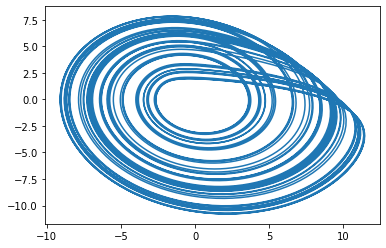

In [38]:
plt.plot(sol[:, 0], sol[:, 1])

In [6]:
sol = Lorenz().make_trajectory(4968, pts_per_period=100, resample=True)
print(sol.shape)

sol = MackeyGlass().make_trajectory(5000, pts_per_period=500, resample=True)
print(sol.shape)


(4968, 3)
(4698, 3)


In [ ]:
TRAIN = 
TEST = 



# Make a collection of standard multivariate series
DATA_PATH = "./data/multivariate_dynamics.json.gz"

# Make a collection of univariate series for single-step prediction
DATA_PATH = "./data/univariate_dynamics.json.gz"

# Repeat both above for different levels of granularity per period (pts_per_period=10, pts_per_period=100)

In [ ]:
# Make attribute files for the specific instantiations included here

#


In [ ]:
# blinking vortex: need to add the timelike variable to the dynamical equation

In [ ]:
# 0.9058,  0.0000, -14.572 for these parameters

In [ ]:
from private.lyap import *
def delay_embedding(data, emb_dim, lag=1):
  data = np.asarray(data)
  min_len = (emb_dim - 1) * lag + 1
  if len(data) < min_len:
    msg = "cannot embed data of length {} with embedding dimension {} " \
        + "and lag {}, minimum required length is {}"
    raise ValueError(msg.format(len(data), emb_dim, lag, min_len))
  m = len(data) - min_len + 1
  indices = np.repeat([np.arange(emb_dim) * lag], m, axis=0)
  indices += np.arange(m).reshape((m, 1))
  return data[indices]
def lyap_r(data, emb_dim=10, lag=None, min_tsep=None, tau=1, min_neighbors=20,
           trajectory_len=20, fit="RANSAC", debug_plot=False, debug_data=False,
           plot_file=None, fit_offset=0):
  """
  Estimates the largest Lyapunov exponent using the algorithm of Rosenstein
  et al. [lr_1]_.
  Explanation of Lyapunov exponents:
    See lyap_e.
  Explanation of the algorithm:
    The algorithm of Rosenstein et al. is only able to recover the largest
    Lyapunov exponent, but behaves rather robust to parameter choices.
    The idea for the algorithm relates closely to the definition of Lyapunov
    exponents. First, the dynamics of the data are reconstructed using a delay
    embedding method with a lag, such that each value x_i of the data is mapped
    to the vector
    X_i = [x_i, x_(i+lag), x_(i+2*lag), ..., x_(i+(emb_dim-1) * lag)]
    For each such vector X_i, we find the closest neighbor X_j using the
    euclidean distance. We know that as we follow the trajectories from X_i and
    X_j in time in a chaotic system the distances between X_(i+k) and X_(j+k)
    denoted as d_i(k) will increase according to a power law
    d_i(k) = c * e^(lambda * k) where lambda is a good approximation of the
    highest Lyapunov exponent, because the exponential expansion along the axis
    associated with this exponent will quickly dominate the expansion or
    contraction along other axes.
    To calculate lambda, we look at the logarithm of the distance trajectory,
    because log(d_i(k)) = log(c) + lambda * k. This gives a set of lines
    (one for each index i) whose slope is an approximation of lambda. We
    therefore extract the mean log trajectory d'(k) by taking the mean of
    log(d_i(k)) over all orbit vectors X_i. We then fit a straight line to
    the plot of d'(k) versus k. The slope of the line gives the desired
    parameter lambda.
  Method for choosing min_tsep:
    Usually we want to find neighbors between points that are close in phase
    space but not too close in time, because we want to avoid spurious
    correlations between the obtained trajectories that originate from temporal
    dependencies rather than the dynamic properties of the system. Therefore it
    is critical to find a good value for min_tsep. One rather plausible
    estimate for this value is to set min_tsep to the mean period of the
    signal, which can be obtained by calculating the mean frequency using the
    fast fourier transform. This procedure is used by default if the user sets
    min_tsep = None.
  Method for choosing lag:
    Another parameter that can be hard to choose by instinct alone is the lag
    between individual values in a vector of the embedded orbit. Here,
    Rosenstein et al. suggest to set the lag to the distance where the
    autocorrelation function drops below 1 - 1/e times its original (maximal)
    value. This procedure is used by default if the user sets lag = None.
  References:
    .. [lr_1] M. T. Rosenstein, J. J. Collins, and C. J. De Luca,
       “A practical method for calculating largest Lyapunov exponents from
       small data sets,” Physica D: Nonlinear Phenomena, vol. 65, no. 1,
       pp. 117–134, 1993.
  Reference Code:
    .. [lr_a] mirwais, "Largest Lyapunov Exponent with Rosenstein's Algorithm",
       url: http://www.mathworks.com/matlabcentral/fileexchange/38424-largest-lyapunov-exponent-with-rosenstein-s-algorithm
    .. [lr_b] Shapour Mohammadi, "LYAPROSEN: MATLAB function to calculate
       Lyapunov exponent",
       url: https://ideas.repec.org/c/boc/bocode/t741502.html
  Args:
    data (iterable of float):
      (one-dimensional) time series
  Kwargs:
    emb_dim (int):
      embedding dimension for delay embedding
    lag (float):
      lag for delay embedding
    min_tsep (float):
      minimal temporal separation between two "neighbors" (default:
      find a suitable value by calculating the mean period of the data)
    tau (float):
      step size between data points in the time series in seconds
      (normalization scaling factor for exponents)
    min_neighbors (int):
      if lag=None, the search for a suitable lag will be stopped when the
      number of potential neighbors for a vector drops below min_neighbors
    trajectory_len (int):
      the time (in number of data points) to follow the distance
      trajectories between two neighboring points
    fit (str):
      the fitting method to use for the line fit, either 'poly' for normal
      least squares polynomial fitting or 'RANSAC' for RANSAC-fitting which
      is more robust to outliers
    debug_plot (boolean):
      if True, a simple plot of the final line-fitting step will
      be shown
    debug_data (boolean):
      if True, debugging data will be returned alongside the result
    plot_file (str):
      if debug_plot is True and plot_file is not None, the plot will be saved
      under the given file name instead of directly showing it through
      ``plt.show()``
    fit_offset (int):
      neglect the first fit_offset steps when fitting
  Returns:
    float:
      an estimate of the largest Lyapunov exponent (a positive exponent is
      a strong indicator for chaos)
    (1d-vector, 1d-vector, list):
      only present if debug_data is True: debug data of the form
      ``(ks, div_traj, poly)`` where ``ks`` are the x-values of the line fit, 
      ``div_traj`` are the y-values and ``poly`` are the line coefficients
      (``[slope, intercept]``).
  """
  # convert data to float to avoid overflow errors in rowwise_euclidean
  data = np.asarray(data, dtype="float32")
  n = len(data)
  max_tsep_factor = 0.25
  if lag is None or min_tsep is None:
    # both the algorithm for lag and min_tsep need the fft
    f = np.fft.rfft(data, n * 2 - 1)
  if min_tsep is None:
    # calculate min_tsep as mean period (= 1 / mean frequency)
    mf = np.fft.rfftfreq(n * 2 - 1) * np.abs(f)
    mf = np.mean(mf[1:]) / np.sum(np.abs(f[1:]))
    min_tsep = int(np.ceil(1.0 / mf))
    if min_tsep > max_tsep_factor * n:
      min_tsep = int(max_tsep_factor * n)
      msg = "signal has very low mean frequency, setting min_tsep = {:d}"
      warnings.warn(msg.format(min_tsep), RuntimeWarning)
  if lag is None:
    # calculate the lag as point where the autocorrelation drops to (1 - 1/e)
    # times its maximum value
    # note: the Wiener–Khinchin theorem states that the spectral
    # decomposition of the autocorrelation function of a process is the power
    # spectrum of that process
    # => we can use fft to calculate the autocorrelation
    acorr = np.fft.irfft(f * np.conj(f))
    acorr = np.roll(acorr, n - 1)
    eps = acorr[n - 1] * (1 - 1.0 / np.e)
    lag = 1
    # small helper function to calculate resulting number of vectors for a
    # given lag value
    def nb_neighbors(lag_value):
      min_len = lyap_r_len(
        emb_dim=emb_dim, lag=i, trajectory_len=trajectory_len,
        min_tsep=min_tsep
      )
      return max(0, n - min_len)
    # find lag
    for i in range(1,n):
      lag = i
      if acorr[n - 1 + i] < eps or acorr[n - 1 - i] < eps:
        break
      if nb_neighbors(i) < min_neighbors:
        msg = "autocorrelation declined too slowly to find suitable lag" \
          + ", setting lag to {}"
        warnings.warn(msg.format(lag), RuntimeWarning)
        break
  min_len = lyap_r_len(
    emb_dim=emb_dim, lag=lag, trajectory_len=trajectory_len,
    min_tsep=min_tsep
  )
  if len(data) < min_len:
    msg = "for emb_dim = {}, lag = {}, min_tsep = {} and trajectory_len = {}" \
      + " you need at least {} datapoints in your time series"
    warnings.warn(
      msg.format(emb_dim, lag, min_tsep, trajectory_len, min_len),
      RuntimeWarning
    )
  # delay embedding
  orbit = delay_embedding(data, emb_dim, lag)
  m = len(orbit)
  # construct matrix with pairwise distances between vectors in orbit
  dists = np.array([rowwise_euclidean(orbit, orbit[i]) for i in range(m)])
  # we do not want to consider vectors as neighbor that are less than min_tsep
  # time steps together => mask the distances min_tsep to the right and left of
  # each index by setting them to infinity (will never be considered as nearest
  # neighbors)
  for i in range(m):
    dists[i, max(0, i - min_tsep):i + min_tsep + 1] = float("inf")
  # check that we have enough data points to continue
  ntraj = m - trajectory_len + 1
  min_traj = min_tsep * 2 + 2 # in each row min_tsep + 1 disances are inf
  if ntraj <= 0:
    msg = "Not enough data points. Need {} additional data points to follow " \
        + "a complete trajectory."
    raise ValueError(msg.format(-ntraj+1))
  if ntraj < min_traj:
    # not enough data points => there are rows where all values are inf
    assert np.any(np.all(np.isinf(dists[:ntraj, :ntraj]), axis=1))
    msg = "Not enough data points. At least {} trajectories are required " \
        + "to find a valid neighbor for each orbit vector with min_tsep={} " \
        + "but only {} could be created."
    raise ValueError(msg.format(min_traj, min_tsep, ntraj))
  assert np.all(np.any(np.isfinite(dists[:ntraj, :ntraj]), axis=1))
  # find nearest neighbors (exclude last columns, because these vectors cannot
  # be followed in time for trajectory_len steps)
  nb_idx = np.argmin(dists[:ntraj, :ntraj], axis=1)
  
  # build divergence trajectory by averaging distances along the trajectory
  # over all neighbor pairs
  div_traj = np.zeros(trajectory_len, dtype=float)
  for k in range(trajectory_len):
    # calculate mean trajectory distance at step k
    indices = (np.arange(ntraj) + k, nb_idx + k)
    div_traj_k = dists[indices]
    # filter entries where distance is zero (would lead to -inf after log)
    nonzero = np.where(div_traj_k != 0)
    if len(nonzero[0]) == 0:
      # if all entries where zero, we have to use -inf
      div_traj[k] = -np.inf
    else:
      div_traj[k] = np.mean(np.log(div_traj_k[nonzero]))
  # filter -inf entries from mean trajectory
  ks = np.arange(trajectory_len)
  finite = np.where(np.isfinite(div_traj))
  ks = ks[finite]
  div_traj = div_traj[finite]
  if len(ks) < 1:
    # if all points or all but one point in the trajectory is -inf, we cannot
    # fit a line through the remaining points => return -inf as exponent
    poly = [-np.inf, 0]
  else:
    # normal line fitting
    poly = poly_fit(ks[fit_offset:], div_traj[fit_offset:], 1, fit=fit)
  if debug_plot:
    plot_reg(ks[fit_offset:], div_traj[fit_offset:], poly, "k", "log(d(k))", fname=plot_file)
  le = poly[0] / tau
  if debug_data:
    return (le, (ks, div_traj, poly))
  else:
    return le